First Attempt

In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=c32a9fdd693078ff21cd25fb0244e105ed43357e0f236e06b4a4208c30666cb3
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
import os
import pandas as pd
import tensorflow as tf

from pathlib import Path
from sklearn.metrics import f1_score
from medmnist import INFO, Evaluator
from tensorflow import keras
from tensorflow.keras import layers

# print("MedMNIST version:", medmnist.__version__)
# print("\n'pneumoniamnist' info dictionary:\n", INFO["pneumoniamnist"])

In [3]:
BATCH_SIZE = 64

def load_npz_data(npz_path):
    """Load train, val, and test arrays from a given .npz file."""
    data = np.load(npz_path)
    
    # Adjust keys if necessary
    train_images = data['train_images']
    train_labels = data['train_labels']
    val_images = data['val_images']
    val_labels = data['val_labels']
    test_images = data['test_images']
    test_labels = data['test_labels']
    
    return (train_images, train_labels), (val_images, val_labels), (test_images, test_labels)

def create_tf_dataset_from_numpy(images, labels, batch_size=BATCH_SIZE):
    """Convert numpy arrays to a tf.data.Dataset, expanding grayscale images to 3 channels."""
    if images.ndim == 3:  # shape: (N, H, W)
        images = np.expand_dims(images, axis=-1)  # shape: (N, H, W, 1)
    if images.shape[-1] == 1:
        images = np.tile(images, (1, 1, 1, 3))   # convert grayscale to RGB
    
    images = images.astype(np.float32) / 255.0
    ds = tf.data.Dataset.from_tensor_slices((images, labels))
    ds = ds.batch(batch_size)
    return ds

In [4]:
base_path = Path("/kaggle/input/tensor-reloaded-multi-task-med-mnist/data")

task_names = [
    "pathmnist",
    "dermamnist",
    "octmnist",
    "pneumoniamnist",
    "retinamnist",
    "breastmnist",
    "bloodmnist",
    "tissuemnist",
    "organamnist",
    "organcmnist",
    "organsmnist"
]

task_to_npz = {task: base_path / f"{task}.npz" for task in task_names}

In [5]:
train_datasets_tf = {}
val_datasets_tf = {}
test_datasets_tf = {}

for task in task_names:
    npz_file = task_to_npz[task]
    # Load data for current task
    (train_imgs, train_lbls), (val_imgs, val_lbls), (test_imgs, test_lbls) = load_npz_data(npz_file)
    
    # Create TensorFlow datasets for each split
    train_datasets_tf[task] = create_tf_dataset_from_numpy(train_imgs, train_lbls, BATCH_SIZE)
    val_datasets_tf[task] = create_tf_dataset_from_numpy(val_imgs, val_lbls, BATCH_SIZE)
    test_datasets_tf[task] = create_tf_dataset_from_numpy(test_imgs, test_lbls, BATCH_SIZE)
    
    print(f"{task}: Loaded {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test samples")

pathmnist: Loaded 89996 train, 10004 val, 7180 test samples
dermamnist: Loaded 7007 train, 1003 val, 2005 test samples
octmnist: Loaded 97477 train, 10832 val, 1000 test samples
pneumoniamnist: Loaded 4708 train, 524 val, 624 test samples
retinamnist: Loaded 1080 train, 120 val, 400 test samples
breastmnist: Loaded 546 train, 78 val, 156 test samples
bloodmnist: Loaded 11959 train, 1712 val, 3421 test samples
tissuemnist: Loaded 165466 train, 23640 val, 47280 test samples
organamnist: Loaded 34581 train, 6491 val, 17778 test samples
organcmnist: Loaded 13000 train, 2392 val, 8268 test samples
organsmnist: Loaded 13940 train, 2452 val, 8829 test samples


In [6]:
total_test_samples = 0
for task in task_names:
    # Summing the sizes of each task's test set
    for images, labels in test_datasets_tf[task]:
        total_test_samples += images.shape[0]
print("Total test samples across all tasks:", total_test_samples)

Total test samples across all tasks: 96941


In [7]:
class MultiTaskKerasModel(keras.Model):
    def __init__(self, task_names, data_flag_to_info):
        super().__init__()
        self.task_names = task_names
        
        # Simple CNN backbone
        self.conv1 = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')
        self.pool1 = layers.MaxPooling2D()
        self.conv2 = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')
        self.pool2 = layers.MaxPooling2D()
        self.flatten = layers.Flatten()
        
        # Classification heads: a Dense layer for each task
        self.heads = {}
        for task in task_names:
            n_classes = len(data_flag_to_info[task]['label'])
            self.heads[task] = layers.Dense(n_classes, name=f'head_{task}')

        self.heads = dict(self.heads)  # convert to normal dict for convenience

    def call(self, x, task=None, training=False):
        """
        Forward pass. If 'task' is provided, return that task's logits. 
        Otherwise return a dict of all tasks' logits.
        """
        # Shared feature extraction
        x = self.conv1(x, training=training)
        x = self.pool1(x)
        x = self.conv2(x, training=training)
        x = self.pool2(x)
        x = self.flatten(x)
        
        if task is not None:
            # Return only the relevant head
            return self.heads[task](x)
        else:
            # Return a dictionary of all heads (not strictly needed for round-robin)
            outputs = {}
            for t in self.task_names:
                outputs[t] = self.heads[t](x)
            return outputs

In [8]:
# Define data_flag_to_info using MedMNIST INFO
data_flag_to_info = {task: INFO[task] for task in task_names}

# Initialize the multi-task model
model = MultiTaskKerasModel(task_names, data_flag_to_info)

# Create a dummy input matching the expected input shape (e.g., (1, 28, 28, 3))
dummy_input = tf.random.normal((1, 28, 28, 3))

# Trigger building of the model for each task to initialize all variables
for t in task_names:
    _ = model(dummy_input, task=t, training=False)

# Now instantiate the optimizer after model variables are created
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'multi_task_keras_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [9]:
total_epochs = 50  # Increased maximum epochs
patience = 5       # Number of epochs with no improvement to wait before stopping
best_f1 = -np.inf  # Initialize best macro F1 score to negative infinity
patience_counter = 0

for epoch in range(total_epochs):
    print(f"Epoch {epoch+1}/{total_epochs}...")
    epoch_loss = 0.0
    total_batches = 0
    
    # Training loop over all tasks
    for task in task_names:
        dataset = train_datasets_tf[task]
        
        for step, (images, labels) in enumerate(dataset):
            images = tf.cast(images, tf.float32)
            with tf.GradientTape() as tape:
                logits = model(images, task=task, training=True)
                loss_value = loss_fn(labels, logits)
            
            grads = tape.gradient(loss_value, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            
            epoch_loss += loss_value.numpy()
            total_batches += 1
    
    avg_loss = epoch_loss / total_batches if total_batches > 0 else 0.0
    print(f"  Training Loss: {avg_loss:.4f}")

    # Evaluate on validation set after each epoch for early stopping
    macro_f1_scores = {}
    for task in task_names:
        all_preds = []
        all_labels = []
        for images, labels in val_datasets_tf[task]:
            images = tf.cast(images, tf.float32)
            logits = model(images, task=task, training=False)
            preds = tf.argmax(logits, axis=1).numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        f1 = f1_score(all_labels, all_preds, average='macro')
        macro_f1_scores[task] = f1
    
    # Calculate harmonic mean of macro F1 scores across tasks
    f1_values = list(macro_f1_scores.values())
    if all(f1 > 0 for f1 in f1_values):
        harmonic_mean_f1 = len(f1_values) / np.sum(1.0 / np.array(f1_values))
    else:
        harmonic_mean_f1 = 0.0
    
    print(f"  Harmonic Mean Macro F1 on Validation: {harmonic_mean_f1:.4f}")
    
    # Early stopping check
    if harmonic_mean_f1 > best_f1:
        best_f1 = harmonic_mean_f1
        patience_counter = 0
        # Optionally save the best model weights here
        best_weights = model.get_weights()
        print("  Improved validation macro F1. Saving model weights.")
    else:
        patience_counter += 1
        print(f"  No improvement for {patience_counter} epoch(s).")
        
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break

# After training, restore best model weights if early stopping occurred
model.set_weights(best_weights)

Epoch 1/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.9433
  Harmonic Mean Macro F1 on Validation: 0.2661
  Improved validation macro F1. Saving model weights.
Epoch 2/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.8458
  Harmonic Mean Macro F1 on Validation: 0.2385
  No improvement for 1 epoch(s).
Epoch 3/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.7825
  Harmonic Mean Macro F1 on Validation: 0.2378
  No improvement for 2 epoch(s).
Epoch 4/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.7465
  Harmonic Mean Macro F1 on Validation: 0.2842
  Improved validation macro F1. Saving model weights.
Epoch 5/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.7023
  Harmonic Mean Macro F1 on Validation: 0.2740
  No improvement for 1 epoch(s).
Epoch 6/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6739
  Harmonic Mean Macro F1 on Validation: 0.2930
  Improved validation macro F1. Saving model weights.
Epoch 7/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6714
  Harmonic Mean Macro F1 on Validation: 0.3067
  Improved validation macro F1. Saving model weights.
Epoch 8/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6560
  Harmonic Mean Macro F1 on Validation: 0.2701
  No improvement for 1 epoch(s).
Epoch 9/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6570
  Harmonic Mean Macro F1 on Validation: 0.3042
  No improvement for 2 epoch(s).
Epoch 10/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6250
  Harmonic Mean Macro F1 on Validation: 0.2652
  No improvement for 3 epoch(s).
Epoch 11/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6193
  Harmonic Mean Macro F1 on Validation: 0.3221
  Improved validation macro F1. Saving model weights.
Epoch 12/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6023
  Harmonic Mean Macro F1 on Validation: 0.3596
  Improved validation macro F1. Saving model weights.
Epoch 13/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5966
  Harmonic Mean Macro F1 on Validation: 0.1837
  No improvement for 1 epoch(s).
Epoch 14/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.6029
  Harmonic Mean Macro F1 on Validation: 0.3450
  No improvement for 2 epoch(s).
Epoch 15/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5792
  Harmonic Mean Macro F1 on Validation: 0.3641
  Improved validation macro F1. Saving model weights.
Epoch 16/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5730
  Harmonic Mean Macro F1 on Validation: 0.3561
  No improvement for 1 epoch(s).
Epoch 17/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5741
  Harmonic Mean Macro F1 on Validation: 0.3154
  No improvement for 2 epoch(s).
Epoch 18/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5681
  Harmonic Mean Macro F1 on Validation: 0.3543
  No improvement for 3 epoch(s).
Epoch 19/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5645
  Harmonic Mean Macro F1 on Validation: 0.3606
  No improvement for 4 epoch(s).
Epoch 20/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5537
  Harmonic Mean Macro F1 on Validation: 0.3736
  Improved validation macro F1. Saving model weights.
Epoch 21/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5470
  Harmonic Mean Macro F1 on Validation: 0.3636
  No improvement for 1 epoch(s).
Epoch 22/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5439
  Harmonic Mean Macro F1 on Validation: 0.3713
  No improvement for 2 epoch(s).
Epoch 23/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5413
  Harmonic Mean Macro F1 on Validation: 0.3388
  No improvement for 3 epoch(s).
Epoch 24/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5362
  Harmonic Mean Macro F1 on Validation: 0.3596
  No improvement for 4 epoch(s).
Epoch 25/50...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:678: UserWarning: Gradients do not exist for variables ['kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias', 'kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


  Training Loss: 0.5344
  Harmonic Mean Macro F1 on Validation: 0.3644
  No improvement for 5 epoch(s).
Early stopping triggered.


In [10]:
print("\nValidation Results:")
for task in task_names:
    all_preds = []
    
    # Collect predictions for each batch in the validation set of the current task
    for images, labels in val_datasets_tf[task]:
        images = tf.cast(images, tf.float32)
        logits = model(images, task=task, training=False)
        preds = tf.argmax(logits, axis=1).numpy()
        all_preds.append(preds)

    # Concatenate predictions across all batches
    all_preds = np.concatenate(all_preds)

    # Determine number of classes for the current task using the length of the label mapping
    n_classes = len(data_flag_to_info[task]['label'])

    # Create a one-hot encoded matrix for predictions
    y_score = np.zeros((all_preds.shape[0], n_classes))
    y_score[np.arange(all_preds.shape[0]), all_preds] = 1

    # Initialize the Evaluator with the correct root directory
    evaluator = Evaluator(task, split='val', root=base_path)

    # Evaluate using one-hot encoded predictions as scores
    metrics = evaluator.evaluate(y_score)

    # Extract accuracy and AUC from the returned Metrics object
    accuracy = metrics.ACC
    auc = metrics.AUC

    print(f"{task} => Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")


Validation Results:
pathmnist => Accuracy: 0.2751, AUC: 0.5890
dermamnist => Accuracy: 0.6770, AUC: 0.5218
octmnist => Accuracy: 0.5980, AUC: 0.6003
pneumoniamnist => Accuracy: 0.9294, AUC: 0.8726
retinamnist => Accuracy: 0.4500, AUC: 0.5083
breastmnist => Accuracy: 0.7564, AUC: 0.5627
bloodmnist => Accuracy: 0.6542, AUC: 0.8093
tissuemnist => Accuracy: 0.5563, AUC: 0.6546
organamnist => Accuracy: 0.8855, AUC: 0.9157
organcmnist => Accuracy: 0.9302, AUC: 0.9555
organsmnist => Accuracy: 0.8418, AUC: 0.8903



Macro F1 Scores per Task:
pathmnist: 0.0212
dermamnist: 0.1145
octmnist: 0.0369
pneumoniamnist: 0.2049
retinamnist: 0.0757
breastmnist: 0.4230
bloodmnist: 0.0362
tissuemnist: 0.0479
organamnist: 0.0063
organcmnist: 0.0074
organsmnist: 0.0074

Harmonic Mean of Macro F1 Scores: 0.0190


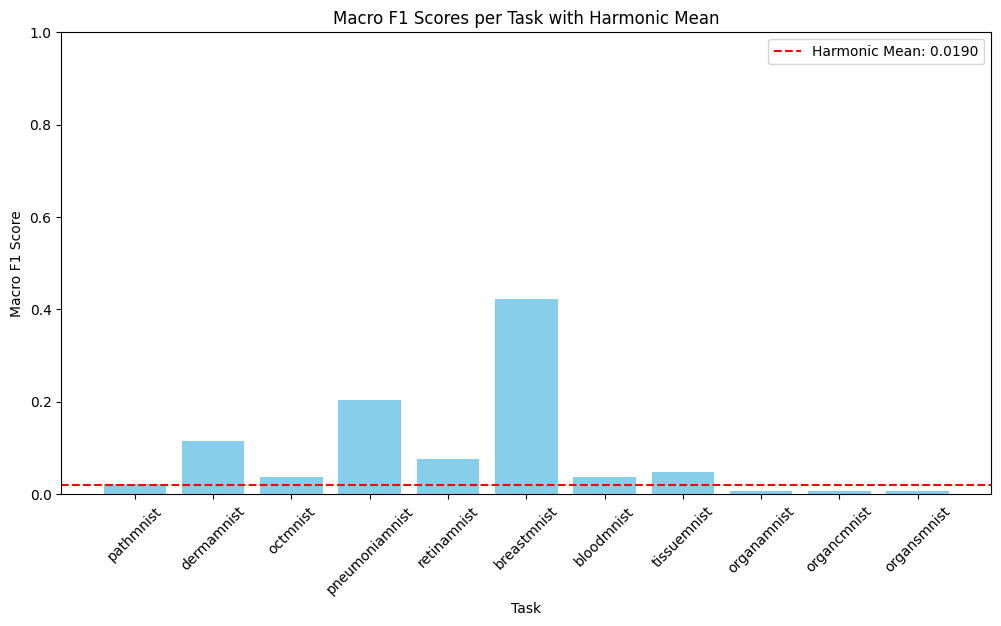

In [11]:
# Dictionary to store macro F1 scores for each task
macro_f1_scores = {}

print("\nMacro F1 Scores per Task:")
for task in task_names:
    all_preds = []
    all_labels = []

    # Collect predictions and true labels for the validation set of the current task
    for images, labels in val_datasets_tf[task]:
        images = tf.cast(images, tf.float32) / 255.0
        logits = model(images, task=task, training=False)
        preds = tf.argmax(logits, axis=1).numpy()
        
        all_preds.append(preds)
        all_labels.append(labels.numpy())

    # Concatenate predictions and labels across all batches
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute macro F1 score for current task
    f1 = f1_score(all_labels, all_preds, average='macro')
    macro_f1_scores[task] = f1
    print(f"{task}: {f1:.4f}")

# Compute harmonic mean of all macro F1 scores
f1_values = list(macro_f1_scores.values())
# Avoid division by zero
if all(f1 > 0 for f1 in f1_values):
    harmonic_mean = len(f1_values) / np.sum(1.0 / np.array(f1_values))
else:
    harmonic_mean = 0.0

print(f"\nHarmonic Mean of Macro F1 Scores: {harmonic_mean:.4f}")

# Plot the macro F1 scores for each task
tasks = list(macro_f1_scores.keys())
scores = list(macro_f1_scores.values())

plt.figure(figsize=(12, 6))
bars = plt.bar(tasks, scores, color='skyblue')
plt.axhline(y=harmonic_mean, color='r', linestyle='--', label=f'Harmonic Mean: {harmonic_mean:.4f}')
plt.xlabel("Task")
plt.ylabel("Macro F1 Score")
plt.title("Macro F1 Scores per Task with Harmonic Mean")
plt.xticks(rotation=45)
plt.legend()
plt.ylim([0, 1])
plt.show()

In [12]:
submission_rows = []
global_id = 0

for task in task_names:
    # We'll just iterate again in batch form
    # We'll keep a local index for each sample in this task
    idx_in_task = 0
    
    for images, _ in test_datasets_tf[task]:
        images = tf.cast(images, tf.float32) / 255.0
        logits = model(images, task=task, training=False)
        preds = tf.argmax(logits, axis=1).numpy()
        
        for pred_label in preds:
            submission_rows.append([
                global_id,
                idx_in_task,
                task,
                int(pred_label)
            ])
            global_id += 1
            idx_in_task += 1

# Convert to DataFrame
submission_df = pd.DataFrame(
    submission_rows,
    columns=["id", "id_image_in_task", "task_name", "label"]
)

print(submission_df.head(10))

# Save to CSV
submission_df.to_csv("submission.csv", index=False)
print("Submission file saved to 'submission.csv'")

   id  id_image_in_task  task_name  label
0   0                 0  pathmnist      1
1   1                 1  pathmnist      1
2   2                 2  pathmnist      1
3   3                 3  pathmnist      1
4   4                 4  pathmnist      1
5   5                 5  pathmnist      1
6   6                 6  pathmnist      1
7   7                 7  pathmnist      1
8   8                 8  pathmnist      1
9   9                 9  pathmnist      1
Submission file saved to 'submission.csv'


In [13]:
submission_df

,id,id_image_in_task,task_name,label
0,0,0,pathmnist,1
1,1,1,pathmnist,1
2,2,2,pathmnist,1
3,3,3,pathmnist,1
4,4,4,pathmnist,1
...,...,...,...,...
96936,96936,8824,organsmnist,1
96937,96937,8825,organsmnist,1
96938,96938,8826,organsmnist,1
96939,96939,8827,organsmnist,1
